In [260]:
import pickle
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [261]:
df_base = pd.read_csv('../data/processed/data_processed_1990_2023.csv', index_col='fecha')
df_base.drop('target', axis=1, inplace=True)
df_base.index = pd.to_datetime(df_base.index)
df_base.head()

,tmin,tmax,tmed,presMin,presMax,dir,velmedia,racha,sol,prec
fecha,,,,,,,,,,
1990-01-01,10.0,16.2,13.1,1016.2,1019.3,20.0,2.5,5.3,1.2,15.6
1990-01-02,7.6,14.6,11.1,1010.6,1019.3,20.0,1.7,15.6,0.8,26.1
1990-01-03,7.6,13.0,10.3,1008.1,1014.4,18.0,2.2,9.7,0.3,6.4
1990-01-04,4.4,14.8,9.6,1014.4,1023.3,31.0,2.2,7.2,4.9,0.0
1990-01-05,6.4,15.8,11.1,1023.1,1026.4,6.0,2.2,6.1,6.7,0.0


In [262]:
tmed = df_base['tmed']

In [263]:
# SEPARACIÓN DATOS TRAIN-TEST

steps = 60
train = tmed[:-steps]
test  = tmed[-steps:]

print(f"Fechas train : {train.index.min()} --- {train.index.max()}  (n={len(train)})")
print(f"Fechas test  : {test.index.min()} --- {test.index.max()}  (n={len(test)})")

Fechas train : 1990-01-01 00:00:00 --- 2023-01-11 00:00:00  (n=12064)
Fechas test  : 2023-01-12 00:00:00 --- 2023-03-12 00:00:00  (n=60)


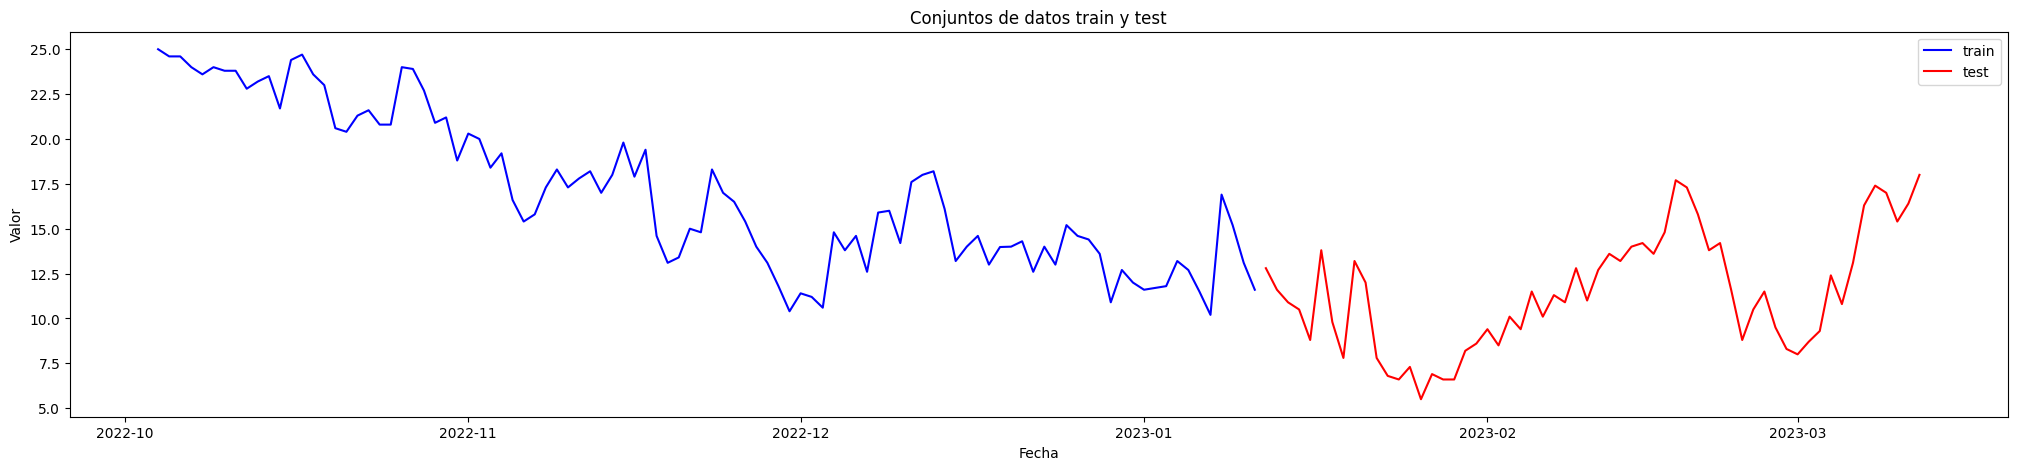

In [264]:
# Graficar los datos de entrenamiento y prueba en el mismo plot
fig, ax = plt.subplots(figsize=(25,5))
plt.plot(train.index[-100:], train[-100:], color='blue', label='train')
plt.plot(test.index, test, color='red', label='test')

# Añadir etiquetas y leyenda
plt.xlabel('Fecha')
plt.ylabel('Valor')
plt.title('Conjuntos de datos train y test')
plt.legend()

# Mostrar el plot
plt.show()

---

STL + ARIMA

In [265]:
with open('stl_arima.model', "rb") as archivo_entrada:
    model_1 = pickle.load(archivo_entrada)

In [266]:
preds_1 = model_1.get_prediction(start=len(train), end=len(train)+60, dynamic=True)

c:\Users\juand\AppData\Local\Programs\Python\Python37\lib\site-packages\statsmodels\tsa\statespace\kalman_filter.py:2287: ValueWarning: Dynamic prediction specified to begin after the end of prediction, and so has no effect.
  ' prediction, and so has no effect.', ValueWarning)


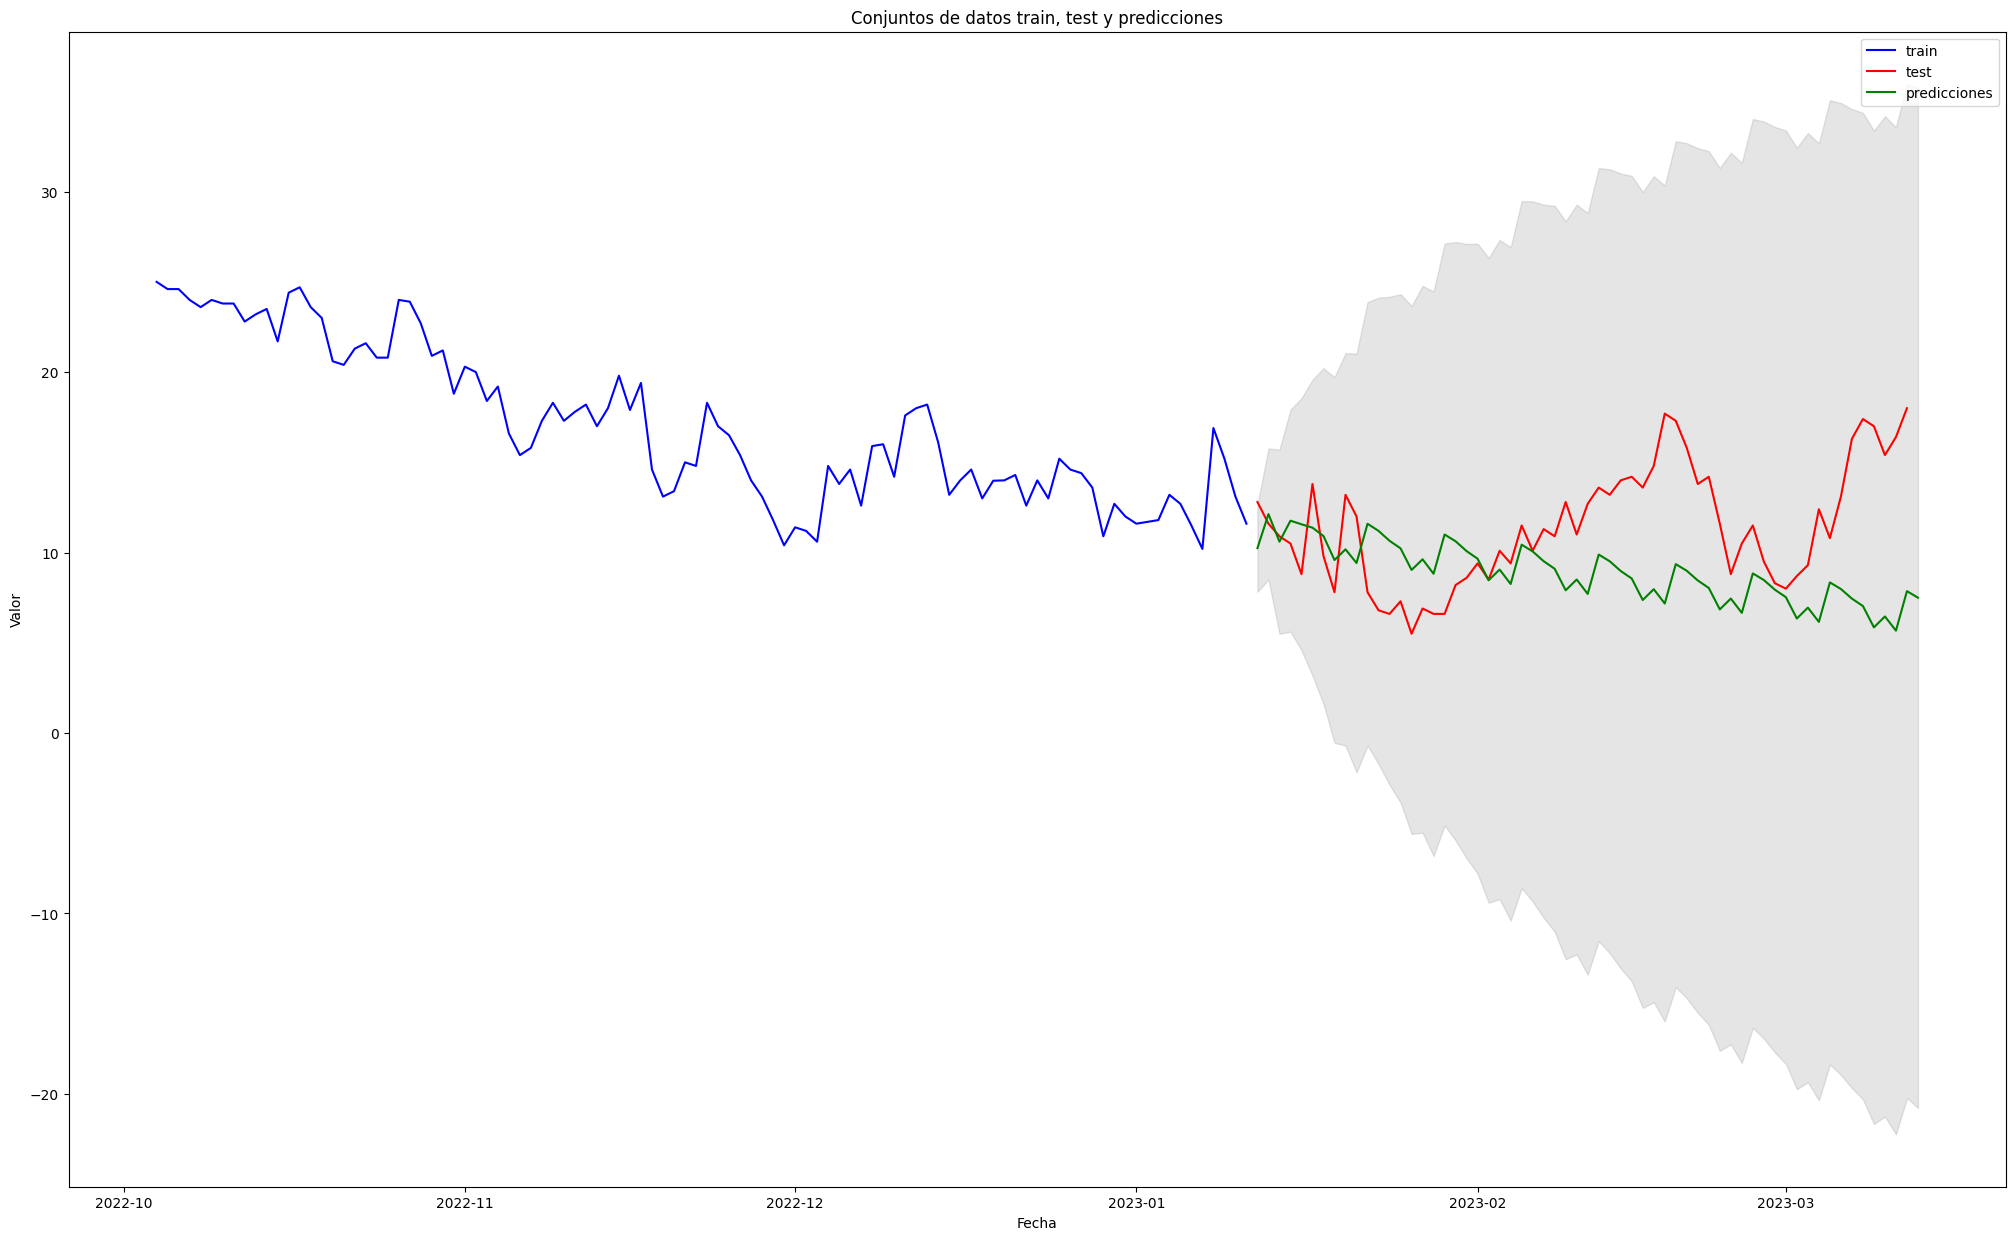

In [267]:
# Obtener el intervalo de confianza de las predicciones
preds_conf_1 = preds_1.conf_int()

# Graficar los datos de entrenamiento, prueba y predicciones en el mismo plot
fig, ax = plt.subplots(figsize=(25,15))
plt.plot(train.index[-100:], train[-100:], color='blue', label='train')
plt.plot(test.index, test, color='red', label='test')
plt.plot(preds_1.predicted_mean.index, preds_1.predicted_mean, color='green', label='predicciones')
plt.fill_between(preds_conf_1.index, preds_conf_1.iloc[:,0], preds_conf_1.iloc[:,1], color='gray', alpha=0.2)

# Añadir etiquetas y leyenda
plt.xlabel('Fecha')
plt.ylabel('Valor')
plt.title('Conjuntos de datos train, test y predicciones')
plt.legend()

# Mostrar el plot
plt.show()

In [268]:
from sklearn.metrics import mean_squared_error

mse = mean_squared_error(test, preds_1.predicted_mean[-len(test):])
print("MSE:", mse)


MSE: 23.303371307245435


---

SARIMAX

In [269]:
with open('sarimax.model', "rb") as archivo_entrada:
    model_2 = pickle.load(archivo_entrada)

In [270]:
exo = df_base.drop('tmed', axis=1)[-60:]

In [271]:
preds_2 = model_2.forecast(steps=60, exog=exo)
preds_2_conf = model_2.get_forecast(steps=60, exog=exo).conf_int()


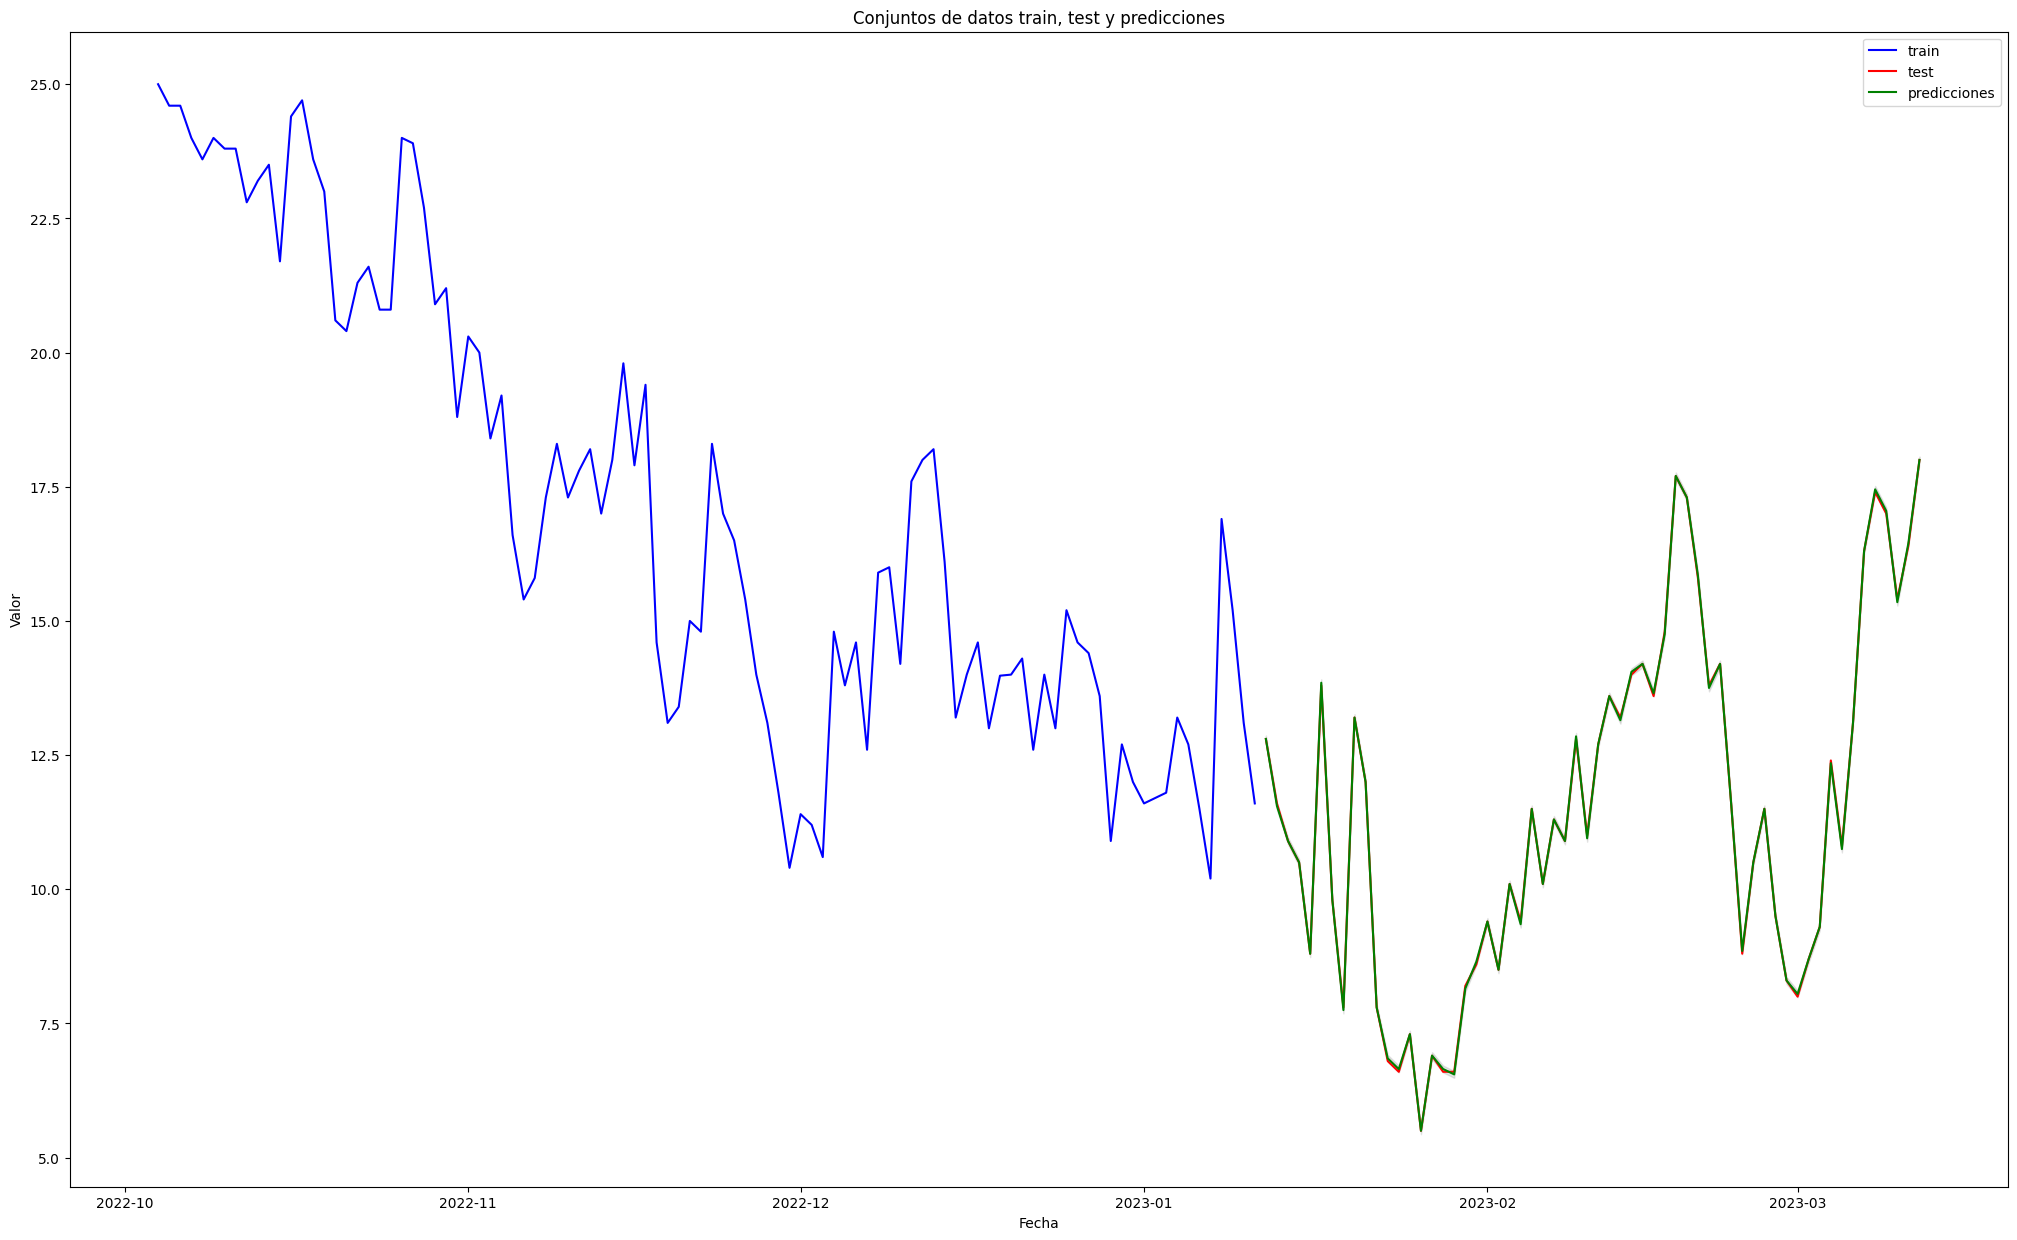

In [275]:
# Graficar los datos de entrenamiento, prueba y predicciones en el mismo plot
fig, ax = plt.subplots(figsize=(25,15))
plt.plot(train.index[-100:], train[-100:], color='blue', label='train')
plt.plot(test.index, test, color='red', label='test')
plt.plot(preds_2.index, preds_2, color='green', label='predicciones')
plt.fill_between(preds_2_conf.index, preds_2_conf.iloc[:,0], preds_2_conf.iloc[:,1], color='gray', alpha=0.2)

# Añadir etiquetas y leyenda
plt.xlabel('Fecha')
plt.ylabel('Valor')
plt.title('Conjuntos de datos train, test y predicciones')
plt.legend()

# Mostrar el plot
plt.show()

In [273]:
mse = mean_squared_error(test, preds_2[-len(test):])
print("MSE:", mse)


MSE: 0.0010875842794987886


---

In [274]:
preds_1 = model_1.get_prediction(start=len(train), end=len(train)+74, dynamic=True)
preds_serie = preds_1.predicted_mean
print(preds_serie[-15:])


2023-03-13    7.498900
2023-03-14    6.967766
2023-03-15    6.559293
2023-03-16    5.378718
2023-03-17    5.985992
2023-03-18    5.200456
2023-03-19    7.392406
2023-03-20    7.031740
2023-03-21    6.502650
2023-03-22    6.096213
2023-03-23    4.917665
2023-03-24    5.526956
2023-03-25    4.743429
2023-03-26    6.937379
2023-03-27    6.578703
Freq: D, Name: predicted_mean, dtype: float64


c:\Users\juand\AppData\Local\Programs\Python\Python37\lib\site-packages\statsmodels\tsa\statespace\kalman_filter.py:2287: ValueWarning: Dynamic prediction specified to begin after the end of prediction, and so has no effect.
  ' prediction, and so has no effect.', ValueWarning)
